In [1]:
trial_number_ml = "007"
random_state_init = 777

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model2_files = ['../../data_for_ml/ml_datasets_set2/model2_rna_bin_protein_bin/data.pkl']

# Load datasets
model2_df = load_and_concatenate_datasets(model2_files)

# Preprocess datasets
X2, y2 = preprocess_data(model2_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X2, y2)

# Output shapes
print(f"Model 2 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 2 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 17:54:20,981] A new study created in memory with name: no-name-8872071b-7439-477c-a61c-99a93e77c880


[I 2024-05-01 17:54:49,186] Trial 2 finished with value: 0.8176586515507065 and parameters: {'n_estimators': 175, 'max_depth': 93, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 2 with value: 0.8176586515507065.


[I 2024-05-01 17:55:28,584] Trial 1 finished with value: 0.8342303355377441 and parameters: {'n_estimators': 351, 'max_depth': 37, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8342303355377441.


[I 2024-05-01 17:55:51,807] Trial 0 finished with value: 0.8460264732473919 and parameters: {'n_estimators': 463, 'max_depth': 52, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8460264732473919.


[I 2024-05-01 17:55:58,249] Trial 3 finished with value: 0.8265814362193847 and parameters: {'n_estimators': 672, 'max_depth': 28, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.8460264732473919.


[I 2024-05-01 17:56:03,213] Trial 5 finished with value: 0.8329594977600341 and parameters: {'n_estimators': 240, 'max_depth': 79, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.8460264732473919.


[I 2024-05-01 17:56:04,295] Trial 7 pruned. 


[I 2024-05-01 17:57:29,262] Trial 9 finished with value: 0.8457054622659717 and parameters: {'n_estimators': 427, 'max_depth': 78, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8460264732473919.


[I 2024-05-01 17:57:46,261] Trial 4 finished with value: 0.8692951980414266 and parameters: {'n_estimators': 821, 'max_depth': 54, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.8692951980414266.


[I 2024-05-01 17:57:48,413] Trial 6 finished with value: 0.8297656416664129 and parameters: {'n_estimators': 651, 'max_depth': 49, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.8692951980414266.


[I 2024-05-01 17:57:52,774] Trial 10 pruned. 


[I 2024-05-01 17:57:55,858] Trial 11 pruned. 


[I 2024-05-01 17:58:10,020] Trial 8 finished with value: 0.8626047603084144 and parameters: {'n_estimators': 608, 'max_depth': 80, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.8692951980414266.


[I 2024-05-01 17:58:21,257] Trial 12 finished with value: 0.8645171121201963 and parameters: {'n_estimators': 202, 'max_depth': 91, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.8692951980414266.


[I 2024-05-01 18:01:19,688] Trial 13 finished with value: 0.8597329310537491 and parameters: {'n_estimators': 990, 'max_depth': 68, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.8692951980414266.


[I 2024-05-01 18:01:30,012] Trial 14 finished with value: 0.8740814108229461 and parameters: {'n_estimators': 966, 'max_depth': 58, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:01:49,919] Trial 15 finished with value: 0.8699341724316583 and parameters: {'n_estimators': 984, 'max_depth': 69, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:01:53,577] Trial 16 finished with value: 0.8680228364774123 and parameters: {'n_estimators': 964, 'max_depth': 64, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:04:31,906] Trial 17 finished with value: 0.8673843700159491 and parameters: {'n_estimators': 792, 'max_depth': 63, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:05:09,853] Trial 20 finished with value: 0.8587775170410101 and parameters: {'n_estimators': 844, 'max_depth': 67, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:05:11,498] Trial 21 pruned. 


[I 2024-05-01 18:05:29,002] Trial 19 finished with value: 0.8590959883785898 and parameters: {'n_estimators': 969, 'max_depth': 64, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:05:29,902] Trial 18 finished with value: 0.8708916181594694 and parameters: {'n_estimators': 988, 'max_depth': 63, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:05:38,669] Trial 23 pruned. 


[I 2024-05-01 18:07:43,177] Trial 24 finished with value: 0.863879153587501 and parameters: {'n_estimators': 705, 'max_depth': 56, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:07:50,744] Trial 25 finished with value: 0.8645160962626601 and parameters: {'n_estimators': 737, 'max_depth': 72, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:07:56,505] Trial 22 finished with value: 0.8590959883785898 and parameters: {'n_estimators': 929, 'max_depth': 44, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:08:18,747] Trial 27 pruned. 


[I 2024-05-01 18:08:20,977] Trial 28 pruned. 


[I 2024-05-01 18:08:27,074] Trial 29 pruned. 


[I 2024-05-01 18:08:30,785] Trial 26 finished with value: 0.8648340596714718 and parameters: {'n_estimators': 896, 'max_depth': 74, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:08:49,073] Trial 30 pruned. 


[I 2024-05-01 18:08:58,654] Trial 31 pruned. 


[I 2024-05-01 18:09:06,862] Trial 32 pruned. 


[I 2024-05-01 18:09:07,096] Trial 33 pruned. 


[I 2024-05-01 18:10:34,744] Trial 34 finished with value: 0.8708895864443971 and parameters: {'n_estimators': 545, 'max_depth': 52, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:10:57,023] Trial 38 finished with value: 0.8657884578266744 and parameters: {'n_estimators': 111, 'max_depth': 53, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:11:37,515] Trial 37 finished with value: 0.8696177328091508 and parameters: {'n_estimators': 795, 'max_depth': 53, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:12:00,705] Trial 39 finished with value: 0.8677038572110647 and parameters: {'n_estimators': 334, 'max_depth': 50, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:12:01,922] Trial 40 pruned. 


[I 2024-05-01 18:12:05,275] Trial 35 finished with value: 0.8699351882891943 and parameters: {'n_estimators': 989, 'max_depth': 51, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:12:15,337] Trial 36 finished with value: 0.8696167169516148 and parameters: {'n_estimators': 996, 'max_depth': 52, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:12:19,722] Trial 42 pruned. 


[I 2024-05-01 18:12:20,026] Trial 43 pruned. 


[I 2024-05-01 18:12:32,059] Trial 44 pruned. 


[I 2024-05-01 18:12:50,340] Trial 46 pruned. 


[I 2024-05-01 18:12:54,087] Trial 45 pruned. 


[I 2024-05-01 18:13:06,612] Trial 47 pruned. 


[I 2024-05-01 18:13:17,745] Trial 41 finished with value: 0.8638776298011968 and parameters: {'n_estimators': 487, 'max_depth': 37, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:13:49,086] Trial 49 finished with value: 0.8702556913418462 and parameters: {'n_estimators': 660, 'max_depth': 62, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


[I 2024-05-01 18:13:58,019] Trial 48 finished with value: 0.8705731468218897 and parameters: {'n_estimators': 946, 'max_depth': 63, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8740814108229461.


Best trial for RandomForestClassifier:
  Value: 0.8740814108229461
  Params: 
    n_estimators: 966
    max_depth: 58
    min_samples_split: 11
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 966, 'max_depth': 58, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 18:14:23,431] A new study created in memory with name: no-name-63b82e29-e982-408a-84ae-4837ed2bdc24


RandomForestClassifier accuracy: 0.8637



[I 2024-05-01 18:14:36,703] Trial 1 finished with value: 0.8367821696685256 and parameters: {'n_estimators': 503, 'max_depth': 3, 'learning_rate': 0.025670715496629568, 'min_child_weight': 10, 'subsample': 0.9988991080522653, 'colsample_bytree': 0.5418992887884426, 'gamma': 0.06579372904171432, 'reg_lambda': 2.9882600602964384, 'reg_alpha': 0.010494446195363915}. Best is trial 1 with value: 0.8367821696685256.


[I 2024-05-01 18:14:37,288] Trial 0 finished with value: 0.8552768719714747 and parameters: {'n_estimators': 280, 'max_depth': 7, 'learning_rate': 0.22255901262145425, 'min_child_weight': 9, 'subsample': 0.7509028344042264, 'colsample_bytree': 0.5964169629010037, 'gamma': 0.3774641649028665, 'reg_lambda': 0.2597925131869897, 'reg_alpha': 0.09679498080779206}. Best is trial 0 with value: 0.8552768719714747.


[I 2024-05-01 18:14:40,588] Trial 2 finished with value: 0.864521683479109 and parameters: {'n_estimators': 615, 'max_depth': 7, 'learning_rate': 0.2708579636256269, 'min_child_weight': 2, 'subsample': 0.5740184240980641, 'colsample_bytree': 0.5273005744154446, 'gamma': 0.44672477808879507, 'reg_lambda': 0.08899189679722208, 'reg_alpha': 2.847964412882786}. Best is trial 2 with value: 0.864521683479109.


[I 2024-05-01 18:14:41,757] Trial 3 finished with value: 0.8492162659108686 and parameters: {'n_estimators': 655, 'max_depth': 5, 'learning_rate': 0.05213485968988698, 'min_child_weight': 7, 'subsample': 0.6620553604871378, 'colsample_bytree': 0.7750229102116724, 'gamma': 4.777602867294156, 'reg_lambda': 0.031393059564794094, 'reg_alpha': 0.014487796544775455}. Best is trial 2 with value: 0.864521683479109.


[I 2024-05-01 18:14:48,770] Trial 5 finished with value: 0.8243521368563274 and parameters: {'n_estimators': 456, 'max_depth': 3, 'learning_rate': 0.06147500223074958, 'min_child_weight': 10, 'subsample': 0.9439638941492379, 'colsample_bytree': 0.9018869680674274, 'gamma': 2.9480844050342925, 'reg_lambda': 0.11615686421844654, 'reg_alpha': 6.126602568135019}. Best is trial 2 with value: 0.864521683479109.


[I 2024-05-01 18:14:50,898] Trial 7 pruned. 


[I 2024-05-01 18:14:54,940] Trial 4 finished with value: 0.85782769024472 and parameters: {'n_estimators': 836, 'max_depth': 6, 'learning_rate': 0.2990343671390683, 'min_child_weight': 8, 'subsample': 0.9026064250913737, 'colsample_bytree': 0.7696526647228321, 'gamma': 1.2380682274536632, 'reg_lambda': 0.26202047709266363, 'reg_alpha': 0.015312366912298368}. Best is trial 2 with value: 0.864521683479109.


[I 2024-05-01 18:14:56,201] Trial 10 pruned. 


[I 2024-05-01 18:14:57,851] Trial 11 pruned. 


[I 2024-05-01 18:14:58,837] Trial 12 pruned. 


[I 2024-05-01 18:15:00,081] Trial 13 pruned. 


[I 2024-05-01 18:15:00,540] Trial 6 finished with value: 0.8527260536982293 and parameters: {'n_estimators': 638, 'max_depth': 3, 'learning_rate': 0.2638786727607496, 'min_child_weight': 10, 'subsample': 0.5270607490992, 'colsample_bytree': 0.7049736669025607, 'gamma': 0.6614672896912466, 'reg_lambda': 0.05533528181564624, 'reg_alpha': 0.5874511116216511}. Best is trial 2 with value: 0.864521683479109.


[I 2024-05-01 18:15:00,778] Trial 8 finished with value: 0.8677079206412094 and parameters: {'n_estimators': 345, 'max_depth': 10, 'learning_rate': 0.04683050902441524, 'min_child_weight': 1, 'subsample': 0.9201368039273401, 'colsample_bytree': 0.8821044645909952, 'gamma': 2.674574294691541, 'reg_lambda': 0.22101365980218524, 'reg_alpha': 0.4601430687328507}. Best is trial 8 with value: 0.8677079206412094.


[I 2024-05-01 18:15:07,742] Trial 16 finished with value: 0.859097512164894 and parameters: {'n_estimators': 199, 'max_depth': 10, 'learning_rate': 0.11217100154551912, 'min_child_weight': 1, 'subsample': 0.6230002645509505, 'colsample_bytree': 0.8800846051528329, 'gamma': 2.5894801315445974, 'reg_lambda': 0.6741785380708653, 'reg_alpha': 1.861697938416064}. Best is trial 8 with value: 0.8677079206412094.


[I 2024-05-01 18:15:14,998] Trial 9 finished with value: 0.8651581182255 and parameters: {'n_estimators': 578, 'max_depth': 10, 'learning_rate': 0.12562110001540752, 'min_child_weight': 10, 'subsample': 0.8124954447446631, 'colsample_bytree': 0.7505138168095176, 'gamma': 0.5963240966875588, 'reg_lambda': 0.45521056107338076, 'reg_alpha': 0.09381514708285486}. Best is trial 8 with value: 0.8677079206412094.


[I 2024-05-01 18:15:21,799] Trial 15 finished with value: 0.8626072999522547 and parameters: {'n_estimators': 915, 'max_depth': 9, 'learning_rate': 0.298986197830139, 'min_child_weight': 2, 'subsample': 0.6460058749125085, 'colsample_bytree': 0.6903061560845412, 'gamma': 1.3526378932728114, 'reg_lambda': 0.54239925991101, 'reg_alpha': 0.044754770878148296}. Best is trial 8 with value: 0.8677079206412094.


[I 2024-05-01 18:15:24,446] Trial 14 finished with value: 0.8648442182468331 and parameters: {'n_estimators': 910, 'max_depth': 9, 'learning_rate': 0.28835025979249757, 'min_child_weight': 2, 'subsample': 0.5960770309351802, 'colsample_bytree': 0.6818796092267001, 'gamma': 1.064446213176144, 'reg_lambda': 0.6676407311729193, 'reg_alpha': 0.04197770765631454}. Best is trial 8 with value: 0.8677079206412094.


[I 2024-05-01 18:15:27,571] Trial 18 finished with value: 0.8677114761425857 and parameters: {'n_estimators': 402, 'max_depth': 9, 'learning_rate': 0.12550199214226537, 'min_child_weight': 4, 'subsample': 0.8695711239665493, 'colsample_bytree': 0.7022396121004584, 'gamma': 1.811049523287863, 'reg_lambda': 0.9247130482623159, 'reg_alpha': 0.06474674489916434}. Best is trial 18 with value: 0.8677114761425857.


[I 2024-05-01 18:15:29,367] Trial 17 finished with value: 0.8654735419904714 and parameters: {'n_estimators': 981, 'max_depth': 9, 'learning_rate': 0.13869904639761985, 'min_child_weight': 3, 'subsample': 0.6386635313135792, 'colsample_bytree': 0.6829621334562239, 'gamma': 1.5569790591769381, 'reg_lambda': 0.6617279531368765, 'reg_alpha': 1.7608175261849757}. Best is trial 18 with value: 0.8677114761425857.


[I 2024-05-01 18:15:33,512] Trial 19 finished with value: 0.8664309877182823 and parameters: {'n_estimators': 355, 'max_depth': 9, 'learning_rate': 0.1361046105762328, 'min_child_weight': 4, 'subsample': 0.8703915217967241, 'colsample_bytree': 0.8360642142632077, 'gamma': 2.0476553149333636, 'reg_lambda': 1.5014446454455384, 'reg_alpha': 0.06278797560060692}. Best is trial 18 with value: 0.8677114761425857.


[I 2024-05-01 18:15:34,504] Trial 23 pruned. 


[I 2024-05-01 18:15:36,584] Trial 20 finished with value: 0.8645211755503409 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.13439443477483048, 'min_child_weight': 4, 'subsample': 0.8662811768336134, 'colsample_bytree': 0.8277828296486873, 'gamma': 1.9031160420215247, 'reg_lambda': 0.01154798261714251, 'reg_alpha': 0.18923125332861113}. Best is trial 18 with value: 0.8677114761425857.


[I 2024-05-01 18:15:36,987] Trial 24 pruned. 


[I 2024-05-01 18:15:38,552] Trial 21 pruned. 


[I 2024-05-01 18:15:41,461] Trial 27 pruned. 


[I 2024-05-01 18:15:43,280] Trial 28 pruned. 


[I 2024-05-01 18:15:45,884] Trial 26 finished with value: 0.8581415902233871 and parameters: {'n_estimators': 283, 'max_depth': 8, 'learning_rate': 0.19876645775382584, 'min_child_weight': 5, 'subsample': 0.9272198095389956, 'colsample_bytree': 0.8207236016923014, 'gamma': 2.2823911978265055, 'reg_lambda': 1.4799645591474442, 'reg_alpha': 0.07483183331799613}. Best is trial 18 with value: 0.8677114761425857.


[I 2024-05-01 18:15:47,222] Trial 25 finished with value: 0.8606964719267769 and parameters: {'n_estimators': 361, 'max_depth': 8, 'learning_rate': 0.19930683871253435, 'min_child_weight': 4, 'subsample': 0.9044557296207107, 'colsample_bytree': 0.8221182620041846, 'gamma': 2.0724094583344876, 'reg_lambda': 1.7757762902672372, 'reg_alpha': 0.03410265872326773}. Best is trial 18 with value: 0.8677114761425857.


[I 2024-05-01 18:15:47,608] Trial 30 pruned. 


[I 2024-05-01 18:15:49,213] Trial 22 finished with value: 0.8590990359511983 and parameters: {'n_estimators': 362, 'max_depth': 8, 'learning_rate': 0.010636094053668728, 'min_child_weight': 4, 'subsample': 0.8864135126690307, 'colsample_bytree': 0.8208442919578275, 'gamma': 2.2062402589923904, 'reg_lambda': 1.2872221234274936, 'reg_alpha': 0.2150209623672101}. Best is trial 18 with value: 0.8677114761425857.


[I 2024-05-01 18:15:51,572] Trial 29 finished with value: 0.8562312701266774 and parameters: {'n_estimators': 193, 'max_depth': 8, 'learning_rate': 0.10109581446741481, 'min_child_weight': 6, 'subsample': 0.77152215234664, 'colsample_bytree': 0.8609051582486994, 'gamma': 3.4278334711877303, 'reg_lambda': 1.6927950832538043, 'reg_alpha': 0.03129006793594138}. Best is trial 18 with value: 0.8677114761425857.


[I 2024-05-01 18:15:55,388] Trial 31 finished with value: 0.8591000518087343 and parameters: {'n_estimators': 202, 'max_depth': 10, 'learning_rate': 0.09859813161606533, 'min_child_weight': 6, 'subsample': 0.7604201565070926, 'colsample_bytree': 0.7234500494500565, 'gamma': 2.8271103639647754, 'reg_lambda': 0.3711280453125892, 'reg_alpha': 0.14094175223392888}. Best is trial 18 with value: 0.8677114761425857.


[I 2024-05-01 18:15:57,765] Trial 32 finished with value: 0.8648391389591523 and parameters: {'n_estimators': 293, 'max_depth': 6, 'learning_rate': 0.050415097409901605, 'min_child_weight': 3, 'subsample': 0.766156433625153, 'colsample_bytree': 0.6414065687112287, 'gamma': 3.6110233553870525, 'reg_lambda': 0.1870149002876866, 'reg_alpha': 0.11082701232348854}. Best is trial 18 with value: 0.8677114761425857.


[I 2024-05-01 18:16:03,608] Trial 34 finished with value: 0.868347910888977 and parameters: {'n_estimators': 290, 'max_depth': 9, 'learning_rate': 0.07011303793585391, 'min_child_weight': 3, 'subsample': 0.6969003612850542, 'colsample_bytree': 0.5920586485439928, 'gamma': 1.562650097780869, 'reg_lambda': 0.1799073323778366, 'reg_alpha': 1.030738988602718}. Best is trial 34 with value: 0.868347910888977.


[I 2024-05-01 18:16:06,162] Trial 33 finished with value: 0.8638852487327178 and parameters: {'n_estimators': 523, 'max_depth': 6, 'learning_rate': 0.04456593050112595, 'min_child_weight': 3, 'subsample': 0.8364960653527952, 'colsample_bytree': 0.6016444945262316, 'gamma': 3.5117602718220247, 'reg_lambda': 0.18573705668695759, 'reg_alpha': 0.10888637614980365}. Best is trial 34 with value: 0.868347910888977.


[I 2024-05-01 18:16:11,733] Trial 35 finished with value: 0.8696228120968316 and parameters: {'n_estimators': 523, 'max_depth': 9, 'learning_rate': 0.042023583062460027, 'min_child_weight': 3, 'subsample': 0.8279406395786598, 'colsample_bytree': 0.6486464467326671, 'gamma': 1.6984468865485023, 'reg_lambda': 0.23104103392243422, 'reg_alpha': 1.084776310850798}. Best is trial 35 with value: 0.8696228120968316.


[I 2024-05-01 18:16:14,670] Trial 36 finished with value: 0.8657950609006593 and parameters: {'n_estimators': 514, 'max_depth': 9, 'learning_rate': 0.07351540696168499, 'min_child_weight': 3, 'subsample': 0.6961362290409873, 'colsample_bytree': 0.6444144909019649, 'gamma': 1.525348126820258, 'reg_lambda': 4.985857339977251, 'reg_alpha': 1.0242817131048314}. Best is trial 35 with value: 0.8696228120968316.


[I 2024-05-01 18:16:15,509] Trial 37 finished with value: 0.8721736303700769 and parameters: {'n_estimators': 253, 'max_depth': 9, 'learning_rate': 0.08011438731018719, 'min_child_weight': 3, 'subsample': 0.7013670165463408, 'colsample_bytree': 0.5691024887448963, 'gamma': 0.8899050726361802, 'reg_lambda': 0.1712192511790162, 'reg_alpha': 0.8875737448181248}. Best is trial 37 with value: 0.8721736303700769.


[I 2024-05-01 18:16:17,709] Trial 38 finished with value: 0.8712177084285699 and parameters: {'n_estimators': 236, 'max_depth': 9, 'learning_rate': 0.07474784713901786, 'min_child_weight': 1, 'subsample': 0.7000845852664895, 'colsample_bytree': 0.5036975227763145, 'gamma': 0.9727757909587621, 'reg_lambda': 0.05852764834626922, 'reg_alpha': 1.0467813587574926}. Best is trial 37 with value: 0.8721736303700769.


[I 2024-05-01 18:16:17,751] Trial 41 pruned. 


[I 2024-05-01 18:16:19,431] Trial 42 pruned. 


[I 2024-05-01 18:16:27,338] Trial 43 finished with value: 0.8673874175885574 and parameters: {'n_estimators': 169, 'max_depth': 7, 'learning_rate': 0.06900782523584993, 'min_child_weight': 1, 'subsample': 0.6794832523408777, 'colsample_bytree': 0.5228570441591772, 'gamma': 0.9712724613700356, 'reg_lambda': 0.0421339415498062, 'reg_alpha': 1.1036811115707068}. Best is trial 37 with value: 0.8721736303700769.


[I 2024-05-01 18:16:29,295] Trial 39 finished with value: 0.875042919980902 and parameters: {'n_estimators': 489, 'max_depth': 9, 'learning_rate': 0.06658101389831485, 'min_child_weight': 1, 'subsample': 0.713054790198402, 'colsample_bytree': 0.5689017046160574, 'gamma': 0.9384942860734214, 'reg_lambda': 0.05470004246767422, 'reg_alpha': 1.1851984130275794}. Best is trial 39 with value: 0.875042919980902.


[I 2024-05-01 18:16:33,898] Trial 44 finished with value: 0.8740844583955546 and parameters: {'n_estimators': 306, 'max_depth': 9, 'learning_rate': 0.06726456672636472, 'min_child_weight': 1, 'subsample': 0.730527712270893, 'colsample_bytree': 0.5151362379933063, 'gamma': 0.8427569106745523, 'reg_lambda': 0.04364023694840349, 'reg_alpha': 0.8612273616468974}. Best is trial 39 with value: 0.875042919980902.


[I 2024-05-01 18:16:36,302] Trial 40 finished with value: 0.8804604882211319 and parameters: {'n_estimators': 451, 'max_depth': 10, 'learning_rate': 0.03663343552490371, 'min_child_weight': 1, 'subsample': 0.7155529837483557, 'colsample_bytree': 0.5680216626993418, 'gamma': 0.969030040042367, 'reg_lambda': 0.06132750904619157, 'reg_alpha': 0.46255298594119854}. Best is trial 40 with value: 0.8804604882211319.


[I 2024-05-01 18:16:38,978] Trial 45 finished with value: 0.868662318796412 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.08562685906210799, 'min_child_weight': 2, 'subsample': 0.7274524799199719, 'colsample_bytree': 0.5845910037684066, 'gamma': 1.232398433415473, 'reg_lambda': 0.11883756759991113, 'reg_alpha': 1.5288959755539222}. Best is trial 40 with value: 0.8804604882211319.


[I 2024-05-01 18:16:51,210] Trial 48 finished with value: 0.8766368004551041 and parameters: {'n_estimators': 313, 'max_depth': 10, 'learning_rate': 0.08503145466344658, 'min_child_weight': 1, 'subsample': 0.7280721695672671, 'colsample_bytree': 0.5018107730988992, 'gamma': 0.3879302956750339, 'reg_lambda': 0.023860385344872285, 'reg_alpha': 0.7011473237232998}. Best is trial 40 with value: 0.8804604882211319.


[I 2024-05-01 18:16:51,442] Trial 47 finished with value: 0.8753593596034092 and parameters: {'n_estimators': 477, 'max_depth': 9, 'learning_rate': 0.08578057043394371, 'min_child_weight': 1, 'subsample': 0.7270579213768192, 'colsample_bytree': 0.515356282718795, 'gamma': 0.6971508286686134, 'reg_lambda': 0.01931226636258534, 'reg_alpha': 0.6388659604416634}. Best is trial 40 with value: 0.8804604882211319.


[I 2024-05-01 18:16:53,853] Trial 46 finished with value: 0.8763168053312202 and parameters: {'n_estimators': 756, 'max_depth': 9, 'learning_rate': 0.06256753125574663, 'min_child_weight': 2, 'subsample': 0.7329001358753346, 'colsample_bytree': 0.5022105727081199, 'gamma': 0.3498028463264906, 'reg_lambda': 0.027549687055200466, 'reg_alpha': 1.5231004068877882}. Best is trial 40 with value: 0.8804604882211319.


[I 2024-05-01 18:16:56,339] Trial 49 finished with value: 0.879505582137161 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.06067291551383549, 'min_child_weight': 1, 'subsample': 0.6639868636479032, 'colsample_bytree': 0.5220545965803052, 'gamma': 0.36768529169664055, 'reg_lambda': 0.029397519789369653, 'reg_alpha': 0.655161623482858}. Best is trial 40 with value: 0.8804604882211319.


Best trial for XGBClassifier:
  Value: 0.8804604882211319
  Params: 
    n_estimators: 451
    max_depth: 10
    learning_rate: 0.03663343552490371
    min_child_weight: 1
    subsample: 0.7155529837483557
    colsample_bytree: 0.5680216626993418
    gamma: 0.969030040042367
    reg_lambda: 0.06132750904619157
    reg_alpha: 0.46255298594119854

Best hyperparameters for XGBClassifier: {'n_estimators': 451, 'max_depth': 10, 'learning_rate': 0.03663343552490371, 'min_child_weight': 1, 'subsample': 0.7155529837483557, 'colsample_bytree': 0.5680216626993418, 'gamma': 0.969030040042367, 'reg_lambda': 0.06132750904619157, 'reg_alpha': 0.46255298594119854}


[I 2024-05-01 18:18:37,006] A new study created in memory with name: no-name-af36b871-8088-40c8-b73c-868b8a8d825f


XGBClassifier accuracy: 0.8726



[I 2024-05-01 18:18:37,916] Trial 3 finished with value: 0.6827964526254838 and parameters: {'boosting_type': 'goss', 'num_leaves': 53, 'max_depth': 3, 'learning_rate': 0.09913370738064475, 'n_estimators': 121, 'min_child_weight': 0.002867833957954846, 'min_child_samples': 828, 'subsample': 0.8742584059214623, 'colsample_bytree': 0.9063249592329816, 'reg_alpha': 1.8735665178873685e-10, 'reg_lambda': 8.581909853534651e-05}. Best is trial 3 with value: 0.6827964526254838.


[I 2024-05-01 18:18:38,424] Trial 4 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 94, 'max_depth': 3, 'learning_rate': 0.017677455681509625, 'n_estimators': 313, 'min_child_weight': 0.01686715927817508, 'min_child_samples': 1367, 'subsample': 0.9213274944944545, 'colsample_bytree': 0.9505677541469062, 'reg_alpha': 0.0001358010202664536, 'reg_lambda': 0.4829335712596012}. Best is trial 3 with value: 0.6827964526254838.


[I 2024-05-01 18:18:39,882] Trial 2 finished with value: 0.5575269964140229 and parameters: {'boosting_type': 'goss', 'num_leaves': 53, 'max_depth': 0, 'learning_rate': 0.3250429822793527, 'n_estimators': 956, 'min_child_weight': 0.0037553613077983333, 'min_child_samples': 1228, 'subsample': 0.9436275920176627, 'colsample_bytree': 0.9903493377616391, 'reg_alpha': 1.8410120348177458e-06, 'reg_lambda': 0.10917369617379434}. Best is trial 3 with value: 0.6827964526254838.


[I 2024-05-01 18:18:41,585] Trial 6 finished with value: 0.6710170765651825 and parameters: {'boosting_type': 'goss', 'num_leaves': 74, 'max_depth': 14, 'learning_rate': 0.21823505333168255, 'n_estimators': 401, 'min_child_weight': 0.05390604594787317, 'min_child_samples': 717, 'subsample': 0.8795023401967154, 'colsample_bytree': 0.8930956075905774, 'reg_alpha': 1.4409250685140072e-08, 'reg_lambda': 1.8488779496222743e-05}. Best is trial 3 with value: 0.6827964526254838.


[I 2024-05-01 18:18:43,254] Trial 0 finished with value: 0.8476213695791301 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 10, 'learning_rate': 0.1879709264188337, 'n_estimators': 419, 'min_child_weight': 0.002960268182805771, 'min_child_samples': 220, 'subsample': 0.8620471449160485, 'colsample_bytree': 0.8378210660507096, 'reg_alpha': 4.4938102139227416e-10, 'reg_lambda': 0.0012026714305365602}. Best is trial 0 with value: 0.8476213695791301.


[I 2024-05-01 18:18:43,531] Trial 7 pruned. 


[I 2024-05-01 18:18:43,682] Trial 9 pruned. 


[I 2024-05-01 18:18:43,856] Trial 10 pruned. 


[I 2024-05-01 18:18:44,029] Trial 11 pruned. 


[I 2024-05-01 18:18:44,137] Trial 12 pruned. 


[I 2024-05-01 18:18:50,469] Trial 8 finished with value: 0.6888707727628278 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 0, 'learning_rate': 0.34285881477652225, 'n_estimators': 382, 'min_child_weight': 0.005796379697529046, 'min_child_samples': 837, 'subsample': 0.9108576626688314, 'colsample_bytree': 0.9112695266495469, 'reg_alpha': 5.649362761915989e-05, 'reg_lambda': 1.3664526430831872e-08}. Best is trial 0 with value: 0.8476213695791301.


[I 2024-05-01 18:19:01,515] Trial 1 finished with value: 0.7631416410162639 and parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'max_depth': 11, 'learning_rate': 0.30971288551599707, 'n_estimators': 786, 'min_child_weight': 0.001333966378322587, 'min_child_samples': 601, 'subsample': 0.958370710884592, 'colsample_bytree': 0.9485830798802407, 'reg_alpha': 0.6263846226450894, 'reg_lambda': 1.2841659535089215e-06}. Best is trial 0 with value: 0.8476213695791301.


[I 2024-05-01 18:19:11,768] Trial 14 finished with value: 0.8380616422352929 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 8, 'learning_rate': 0.32495138417309943, 'n_estimators': 533, 'min_child_weight': 0.0010591855181470932, 'min_child_samples': 217, 'subsample': 0.8326153462548581, 'colsample_bytree': 0.8172194410724156, 'reg_alpha': 0.307773901255996, 'reg_lambda': 1.106147230638849e-07}. Best is trial 0 with value: 0.8476213695791301.


[I 2024-05-01 18:19:12,325] Trial 5 finished with value: 0.8476244171517386 and parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'max_depth': 5, 'learning_rate': 0.3485941401302996, 'n_estimators': 814, 'min_child_weight': 0.006103524867871307, 'min_child_samples': 227, 'subsample': 0.9450159161473782, 'colsample_bytree': 0.9462387048617844, 'reg_alpha': 1.7146768415510715e-08, 'reg_lambda': 1.4738022469089228e-06}. Best is trial 5 with value: 0.8476244171517386.


[I 2024-05-01 18:19:14,068] Trial 13 finished with value: 0.8664335273621229 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'max_depth': 8, 'learning_rate': 0.1578637652891063, 'n_estimators': 542, 'min_child_weight': 0.020391770777920475, 'min_child_samples': 68, 'subsample': 0.8166867300220086, 'colsample_bytree': 0.8075979161425051, 'reg_alpha': 0.523568880712198, 'reg_lambda': 1.2827405204273875e-07}. Best is trial 13 with value: 0.8664335273621229.


[I 2024-05-01 18:19:23,142] Trial 16 finished with value: 0.8626052682371824 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 7, 'learning_rate': 0.16764060097095576, 'n_estimators': 603, 'min_child_weight': 0.0010034954794415404, 'min_child_samples': 139, 'subsample': 0.8286080437884997, 'colsample_bytree': 0.8044340833406989, 'reg_alpha': 5.9323643818507145e-08, 'reg_lambda': 1.217531970777107e-07}. Best is trial 13 with value: 0.8664335273621229.


[I 2024-05-01 18:19:23,842] Trial 15 finished with value: 0.8288142910838184 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'max_depth': 9, 'learning_rate': 0.19409530494943994, 'n_estimators': 561, 'min_child_weight': 0.0010976895603370294, 'min_child_samples': 214, 'subsample': 0.9886545561371431, 'colsample_bytree': 0.8063255568446058, 'reg_alpha': 0.7354263079668211, 'reg_lambda': 2.511415735210176e-07}. Best is trial 13 with value: 0.8664335273621229.


[I 2024-05-01 18:19:24,126] Trial 19 pruned. 


[I 2024-05-01 18:19:24,848] Trial 20 pruned. 


[I 2024-05-01 18:19:31,281] Trial 22 finished with value: 0.8415668586637409 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 4, 'learning_rate': 0.061347715204594366, 'n_estimators': 245, 'min_child_weight': 0.03716603462163083, 'min_child_samples': 33, 'subsample': 0.8322918165088632, 'colsample_bytree': 0.8390696730303391, 'reg_alpha': 0.0019373644382887456, 'reg_lambda': 1.23604876024839e-10}. Best is trial 13 with value: 0.8664335273621229.


[I 2024-05-01 18:19:32,036] Trial 21 finished with value: 0.8444325927731894 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 6, 'learning_rate': 0.03928563902643285, 'n_estimators': 213, 'min_child_weight': 0.013703266315317604, 'min_child_samples': 36, 'subsample': 0.836138265295618, 'colsample_bytree': 0.8487874183186289, 'reg_alpha': 0.0007758114196159721, 'reg_lambda': 6.145537902711409e-09}. Best is trial 13 with value: 0.8664335273621229.


[I 2024-05-01 18:19:33,413] Trial 17 finished with value: 0.8648432023892969 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'max_depth': 7, 'learning_rate': 0.15857156078801726, 'n_estimators': 583, 'min_child_weight': 0.012725693811212269, 'min_child_samples': 20, 'subsample': 0.9927252426653465, 'colsample_bytree': 0.8482468723220781, 'reg_alpha': 1.382650261574715e-07, 'reg_lambda': 0.0032136564505460654}. Best is trial 13 with value: 0.8664335273621229.


[I 2024-05-01 18:19:34,686] Trial 25 pruned. 


[I 2024-05-01 18:19:35,742] Trial 26 pruned. 


[I 2024-05-01 18:19:39,885] Trial 24 pruned. 


[I 2024-05-01 18:19:50,219] Trial 18 finished with value: 0.8642032121415294 and parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'max_depth': 6, 'learning_rate': 0.49969529377187494, 'n_estimators': 624, 'min_child_weight': 0.020416159769520596, 'min_child_samples': 34, 'subsample': 0.992730260020801, 'colsample_bytree': 0.8630161141179601, 'reg_alpha': 9.635345350432081e-08, 'reg_lambda': 1.195287925355116e-07}. Best is trial 13 with value: 0.8664335273621229.


[I 2024-05-01 18:19:52,615] Trial 29 pruned. 


[I 2024-05-01 18:19:57,691] Trial 28 finished with value: 0.8629293267912107 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 8, 'learning_rate': 0.15551903404192755, 'n_estimators': 654, 'min_child_weight': 0.0905835456959288, 'min_child_samples': 59, 'subsample': 0.8524013016398982, 'colsample_bytree': 0.8251673681451182, 'reg_alpha': 9.706034728504636e-08, 'reg_lambda': 4.681270439044772e-06}. Best is trial 13 with value: 0.8664335273621229.


[I 2024-05-01 18:19:59,796] Trial 31 pruned. 


[I 2024-05-01 18:20:21,353] Trial 27 finished with value: 0.8673904651611657 and parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'max_depth': 8, 'learning_rate': 0.14883970815065664, 'n_estimators': 660, 'min_child_weight': 0.04799544000440852, 'min_child_samples': 58, 'subsample': 0.998730967253428, 'colsample_bytree': 0.8246646470442764, 'reg_alpha': 5.729434505990163e-09, 'reg_lambda': 1.3345817231903355e-07}. Best is trial 27 with value: 0.8673904651611657.


[I 2024-05-01 18:20:26,862] Trial 33 pruned. 


[I 2024-05-01 18:20:33,336] Trial 34 pruned. 


[I 2024-05-01 18:20:34,642] Trial 23 finished with value: 0.8718510956023527 and parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'max_depth': 12, 'learning_rate': 0.16865346532126868, 'n_estimators': 671, 'min_child_weight': 0.011403164667845581, 'min_child_samples': 44, 'subsample': 0.8322962168134761, 'colsample_bytree': 0.8644258569574385, 'reg_alpha': 8.68773447489118e-06, 'reg_lambda': 3.3325287521939525e-09}. Best is trial 23 with value: 0.8718510956023527.


[I 2024-05-01 18:20:34,996] Trial 32 finished with value: 0.850175743353752 and parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'max_depth': 10, 'learning_rate': 0.20991521319899437, 'n_estimators': 710, 'min_child_weight': 0.016395456485275073, 'min_child_samples': 186, 'subsample': 0.9419441531476483, 'colsample_bytree': 0.8637980934802608, 'reg_alpha': 0.04212098441496664, 'reg_lambda': 0.0004395017324136002}. Best is trial 23 with value: 0.8718510956023527.


[I 2024-05-01 18:20:37,444] Trial 30 finished with value: 0.8683494346752811 and parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'max_depth': 8, 'learning_rate': 0.39228675655888995, 'n_estimators': 681, 'min_child_weight': 0.09925917288814211, 'min_child_samples': 52, 'subsample': 0.9801514868077453, 'colsample_bytree': 0.8274452890607306, 'reg_alpha': 4.687905308455647e-06, 'reg_lambda': 0.03091580291183171}. Best is trial 23 with value: 0.8718510956023527.


[I 2024-05-01 18:20:38,650] Trial 37 pruned. 


[I 2024-05-01 18:20:39,884] Trial 36 pruned. 


[I 2024-05-01 18:20:41,088] Trial 38 pruned. 


[I 2024-05-01 18:20:45,329] Trial 39 pruned. 


[I 2024-05-01 18:20:45,345] Trial 40 pruned. 


[I 2024-05-01 18:20:45,861] Trial 42 pruned. 


[I 2024-05-01 18:20:47,457] Trial 43 pruned. 


[I 2024-05-01 18:21:13,184] Trial 45 finished with value: 0.8584641249911114 and parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'max_depth': 4, 'learning_rate': 0.18075491842185246, 'n_estimators': 645, 'min_child_weight': 0.03501144002677301, 'min_child_samples': 93, 'subsample': 0.9627906314131165, 'colsample_bytree': 0.8419444368494898, 'reg_alpha': 2.911095968923548e-07, 'reg_lambda': 0.0092160774408181}. Best is trial 23 with value: 0.8718510956023527.


[I 2024-05-01 18:21:19,696] Trial 44 finished with value: 0.8616483304381394 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 8, 'learning_rate': 0.1782663261271613, 'n_estimators': 646, 'min_child_weight': 0.044223543204071146, 'min_child_samples': 124, 'subsample': 0.9648936597317044, 'colsample_bytree': 0.840573790677622, 'reg_alpha': 4.732761513914505e-06, 'reg_lambda': 0.057704323971436294}. Best is trial 23 with value: 0.8718510956023527.


[I 2024-05-01 18:21:25,020] Trial 47 pruned. 


[I 2024-05-01 18:21:25,287] Trial 48 pruned. 


[I 2024-05-01 18:21:34,322] Trial 41 finished with value: 0.8696202724529913 and parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'max_depth': 11, 'learning_rate': 0.2569392835798701, 'n_estimators': 839, 'min_child_weight': 0.06202897373756126, 'min_child_samples': 126, 'subsample': 0.8807312532677378, 'colsample_bytree': 0.8293916815859392, 'reg_alpha': 4.115473130738408e-06, 'reg_lambda': 1.3297291056475893e-10}. Best is trial 23 with value: 0.8718510956023527.


[I 2024-05-01 18:21:39,516] Trial 35 finished with value: 0.8696253517406719 and parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 10, 'learning_rate': 0.13675247528277215, 'n_estimators': 649, 'min_child_weight': 0.05822159335168722, 'min_child_samples': 26, 'subsample': 0.9799157123439689, 'colsample_bytree': 0.8184339666727866, 'reg_alpha': 1.8680660111412366e-09, 'reg_lambda': 4.828477633667134e-07}. Best is trial 23 with value: 0.8718510956023527.


[I 2024-05-01 18:21:42,414] Trial 46 finished with value: 0.8562307621979095 and parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'max_depth': 7, 'learning_rate': 0.14997049046701866, 'n_estimators': 676, 'min_child_weight': 0.04311460061591312, 'min_child_samples': 156, 'subsample': 0.9324536690911907, 'colsample_bytree': 0.8258668726993557, 'reg_alpha': 1.769402913726546e-08, 'reg_lambda': 9.40964832798771e-07}. Best is trial 23 with value: 0.8718510956023527.


[I 2024-05-01 18:22:01,371] Trial 49 finished with value: 0.8702592468432225 and parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'max_depth': 7, 'learning_rate': 0.19630087695934528, 'n_estimators': 578, 'min_child_weight': 0.003400686769561247, 'min_child_samples': 25, 'subsample': 0.9724603575068408, 'colsample_bytree': 0.8240365973196795, 'reg_alpha': 1.4519851411849265e-05, 'reg_lambda': 2.6131647290606127e-08}. Best is trial 23 with value: 0.8718510956023527.


Best trial for LGBMClassifier:
  Value: 0.8718510956023527
  Params: 
    boosting_type: dart
    num_leaves: 83
    max_depth: 12
    learning_rate: 0.16865346532126868
    n_estimators: 671
    min_child_weight: 0.011403164667845581
    min_child_samples: 44
    subsample: 0.8322962168134761
    colsample_bytree: 0.8644258569574385
    reg_alpha: 8.68773447489118e-06
    reg_lambda: 3.3325287521939525e-09

Best hyperparameters for LGBMClassifier: {'boosting_type': 'dart', 'num_leaves': 83, 'max_depth': 12, 'learning_rate': 0.16865346532126868, 'n_estimators': 671, 'min_child_weight': 0.011403164667845581, 'min_child_samples': 44, 'subsample': 0.8322962168134761, 'colsample_bytree': 0.8644258569574385, 'reg_alpha': 8.68773447489118e-06, 'reg_lambda': 3.3325287521939525e-09}


LGBMClassifier accuracy: 0.8752
LGBMClassifier accuracy: 0.8752



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_007/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

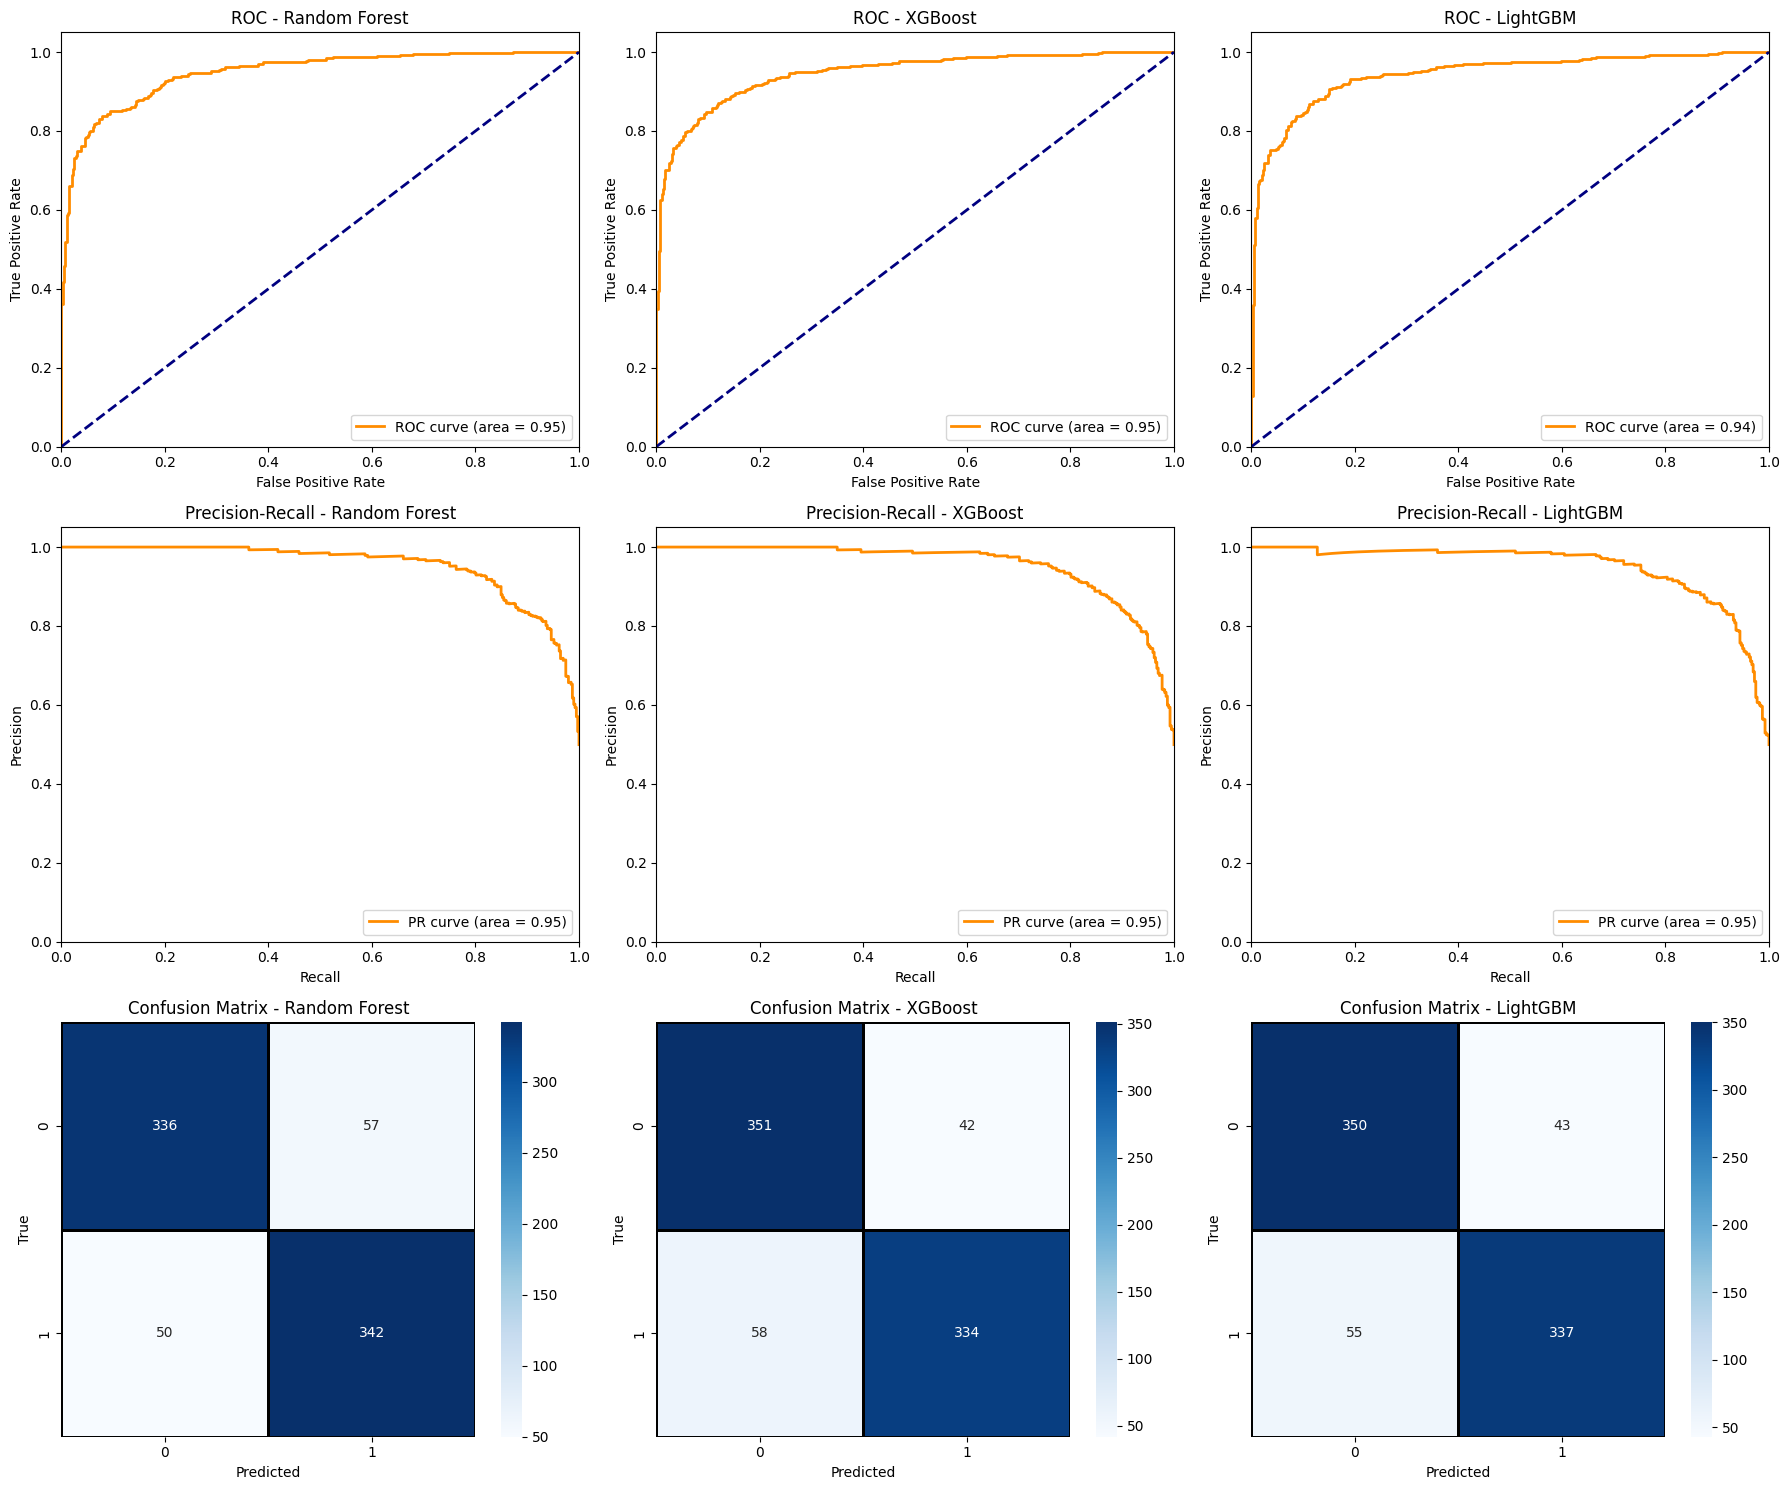

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.8636942675159236, 'Precision': 0.8571428571428571, 'Recall': 0.8724489795918368, 'F1 Score': 0.8647281921618204, 'ROC AUC': 0.9469997922833254}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.8726114649681529, 'Precision': 0.8882978723404256, 'Recall': 0.8520408163265306, 'F1 Score': 0.8697916666666666, 'ROC AUC': 0.9457664745287427}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.8751592356687898, 'Precision': 0.8868421052631579, 'Recall': 0.8596938775510204, 'F1 Score': 0.873056994818653, 'ROC AUC': 0.9425923040972113}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.8751592356687898,
 'Precision': 0.8868421052631579,
 'Recall': 0.8596938775510204,
 'F1 Score': 0.873056994818653,
 'ROC AUC': 0.9425923040972113}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: LightGBM with Accuracy: 0.8752


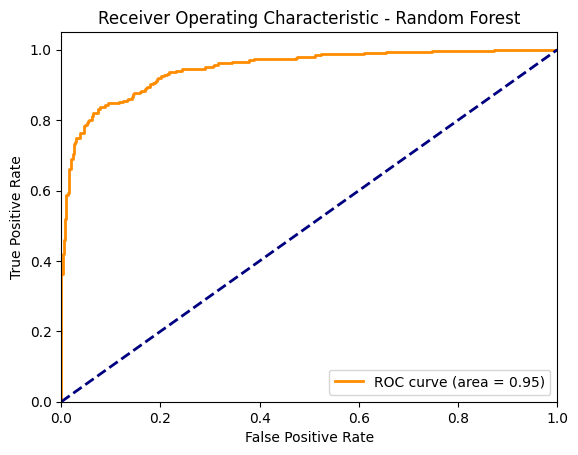

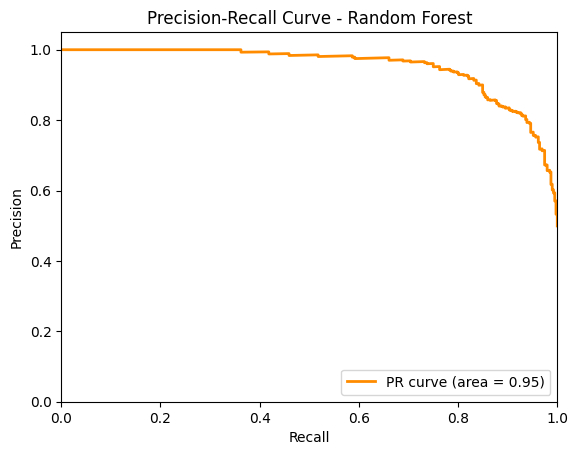

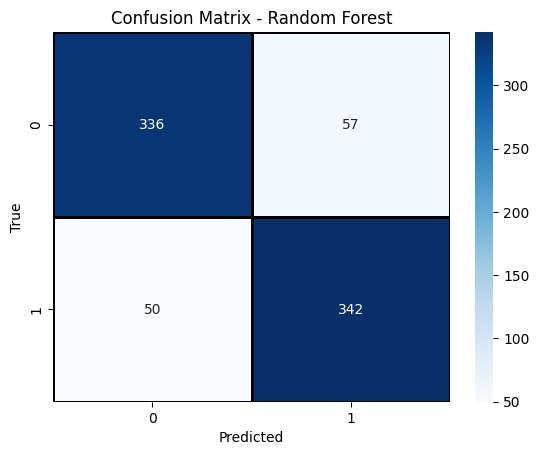

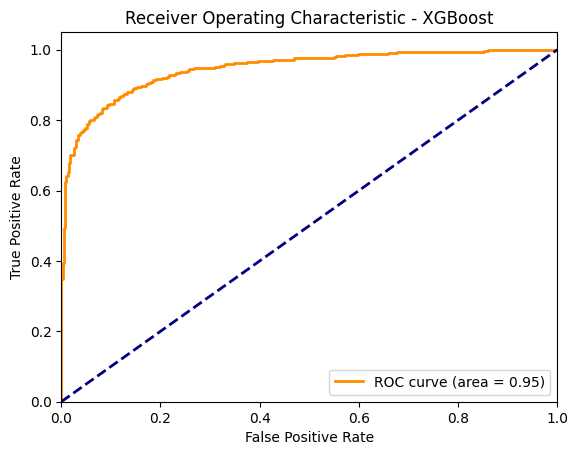

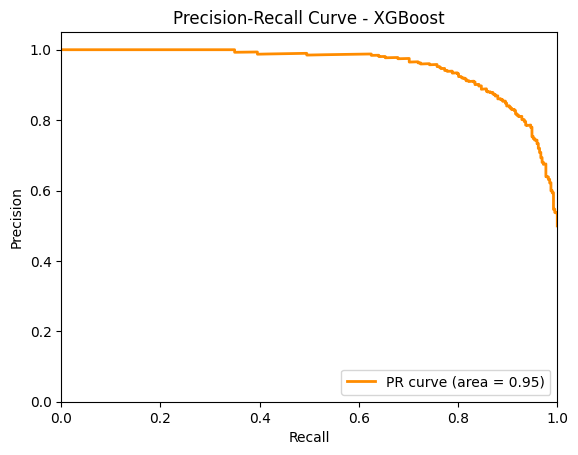

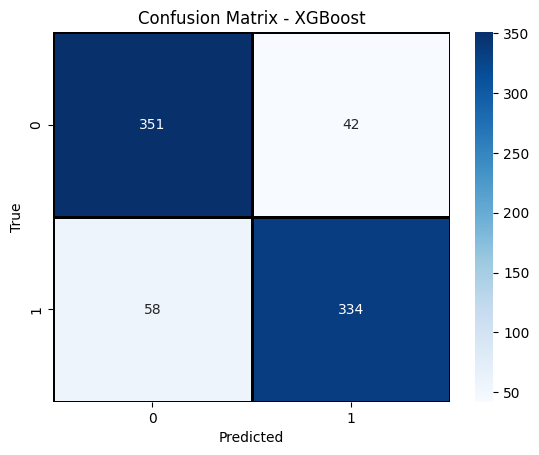

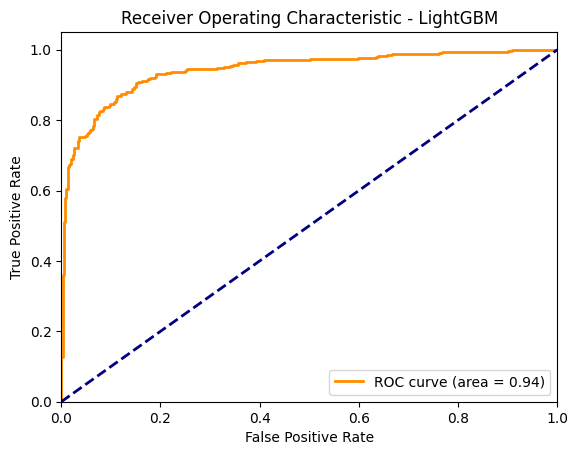

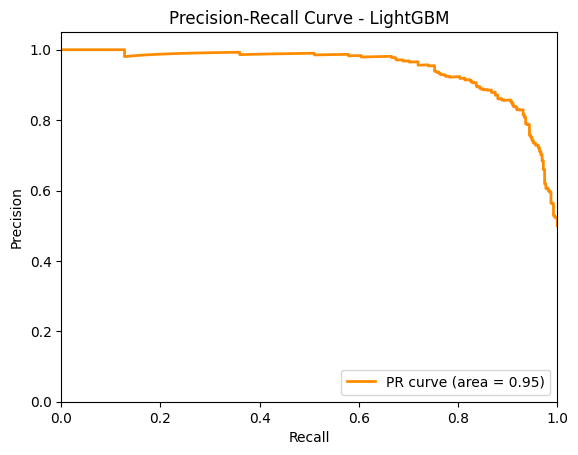

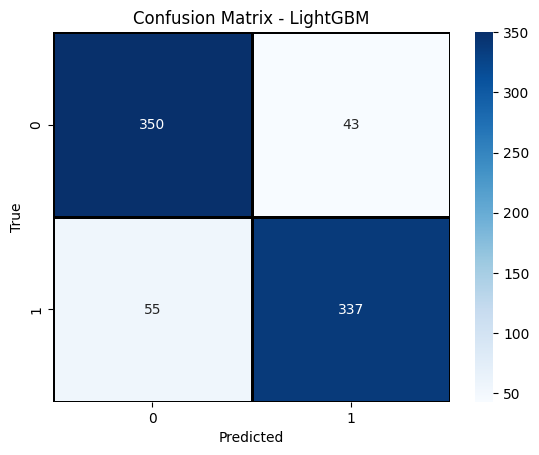

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

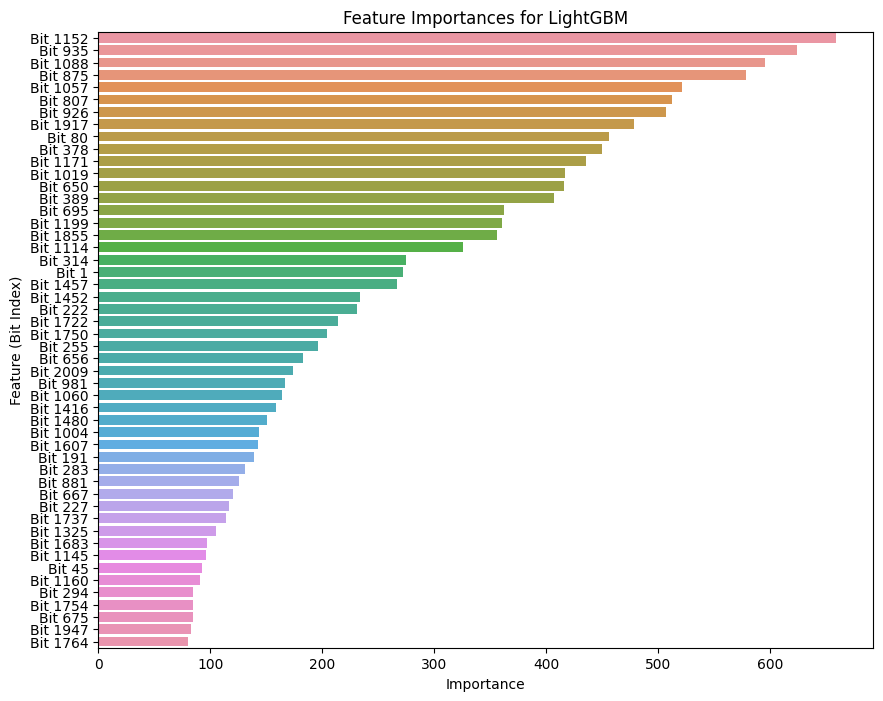

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
